# Base Code for Calculating Atom Movement

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from scipy.integrate import odeint
import pprint
from ipywidgets import interact, interactive, fixed, interact_manual, jslink
import ipywidgets as widgets
import ipyvolume as ipv
import ipyvolume.pylab as p3
import traitlets
import time, sys
from IPython.core.display import clear_output

In [2]:
# define the number of floating atoms
floaters = np.zeros(15*3) # set number of floaters and multiply by 3 to have 3 coords for each
n = len(floaters)
m = n/3                    # total atoms in the chain

# set the positions of the floating atoms
count = 0
k = 1.7
for i in range(0,n,3):
    floaters[i] = count
    floaters[i+1] = k*count
    floaters[i+2] = 1
    count += 1

In [3]:
# set number of substrate atoms (substrate will be 2*ns + 1 side lengths)
ns = 5

In [4]:
# set the substrate parameters
h_x = 1
h_y = 1

In [5]:
# set the VDW parameters
w = 1
sigma = 1

In [6]:
# set the spring parameters
k_s = 5
l = 1

In [7]:
# define the time interval for the gradient flow
t = np.linspace(0,6,20)

In [8]:
# this is the RHS of the system of ODEs solved by odeint. It returns the forces
# acting on each floater in the x, y and z directions
def spring_and_VDWForce(floaters, t):

    # compute number of atoms
    m = int(len(floaters)/3)
    n = int(len(floaters))

    # split the atoms into 1x3 arrays
    r = [[0 for i in range(3)] for j in range(m)]
    for i in range(m):
        r[i] = floaters[i*3:i*3+3]

    # initialize arrays for the spring forces and VDW forces
    combined_spring_forces = np.zeros(n)
    combined_VDW_forces = np.zeros(n)
    VDW_force = np.zeros((m, 3))
    spring_force = np.zeros((m, 3))

    # define the size of the substrate surrounding the floaters
    a = np.arange(-ns,ns+1,1)

    # compute the distances of the floating atom from the substrate atoms
    # and the VDW forces acting on them as a result
    for j in range(len(a)):
        for i in range(len(a)):
            for k in range(m):

                # compute the offsets
                k_x = (r[k][0] + .5)%h_x
                k_y = (r[k][1] + .5)%h_y

                # compute dx, dy, dz and rhat
                dx = k_x - .5 + a[i]*h_x
                dy = k_y - .5 + a[j]*h_y
                dz = r[k][2]
                rhat = np.sqrt(dx**2 + dy**2 + dz**2)
                gradV_common = (12*w*((sigma**6)/(rhat**8)-(sigma**12)/(rhat**14)))

                # this is the gradient of V (computed by hand), it is used to compute the
                # VDW forces acting on the floating atoms
                VDW_force[k] = -gradV_common*np.array([dx, dy, dz])

            # combine the VDW forces for all floating atoms
            combined_VDW_forces += np.hstack(VDW_force)

    # this is the gradient of E_s (computed by hand), it is used to compute the
    # spring forces acting on the atoms (m = number of atoms in the chain)
    for i in range(m-1):
        gradE_common = k_s*(norm(r[i]-r[i+1]) - l)/norm(r[i] - r[i+1])
        current_sf = -gradE_common*np.array([(r[i][0]-r[i+1][0]),(r[i][1]-r[i+1][1]),(r[i][2]-r[i+1][2])])
        spring_force[i] += current_sf
        spring_force[i+1] = -current_sf


    combined_spring_forces = np.hstack(spring_force)
    total_spring_and_VDW_force = np.add(combined_spring_forces, combined_VDW_forces)

    return total_spring_and_VDW_force


In [9]:
def VDW_energy(r):
    
    # separate r into its indices
    x = r[0]
    y = r[1]
    z = r[2]

    # Offset k (x mod h for the x-coordinate of the floating atom)
    k_x = x%h_x
    k_y = y%h_y

    E_v = 0
    a = np.arange(-ns,ns+1,1) # set the values of r_j which we need

    # compute the total VDW energy, E_v
    for i in range(len(a)):
        for j in range(len(a)):
            r = np.sqrt((k_x + a[i]*h_x)**2 + (k_y + a[j]*h_y)**2 + z**2)
            E_v += w*((sigma**12/r**12) - 2*(sigma**6/r**6))
    
    return E_v

In [10]:
def spring_energy(atom, row):
    
    # so I need the atom before the one being analyzed and the atom after it, this if-else statement determines if the
    # atom in question is one of the atoms at the end of the chain or not, and handles the computations accordingly
    if (atom == 0):
        r1 = gFlow[row, :3]
        r2 = gFlow[row, 3:6]
        E_s = .5*k_s*(norm(r1 - r2) - l)**2
    elif (atom == int(m)-1):
        r1 = gFlow[row, -6:-3]
        r2 = gFlow[row, -3:]
        E_s = -.5*k_s*(norm(r1 - r2) - l)**2
    else:
        r1 = gFlow[row, atom*3-3:atom*3]
        r2 = gFlow[row, atom*3:atom*3+3]
        r3 = gFlow[row, atom*3+3:atom*3+6]
        E_s = -.5*k_s*(norm(r1 - r2) - l)**2
        E_s += .5*k_s*(norm(r2 - r3) - l)**2
    
    return E_s

In [11]:
%%time
# compute the changing positions of the atoms as a result of the spring
# and VDW forces acting on them
gFlow = odeint(all_forces, floaters, t, atol=1.4e-10)

CPU times: user 43.6 s, sys: 245 ms, total: 43.9 s
Wall time: 45 s


In [12]:
# define the arrays to hold the system energy values
total_energies = np.zeros((len(gFlow), int(m)))
total_system_energy = np.zeros(len(gFlow))

# compute the total energy at each time step for each individual floater
for i in range(int(m)):
    for j in range(len(gFlow)):
        total_energies[j][i] += VDW_energy(gFlow[j][i*3:i*3+3]) + spring_energy(i, j)

# combine the individual energies into the total system energy at each time step
for i in range(int(m)):
    for j in range(len(gFlow)):
        total_system_energy[j] += total_energies[j][i]


pprint.pprint(total_system_energy)

array([-37.20991151, -55.47422983, -65.5178744 , -69.03760908,
       -69.57593977, -69.57584176, -69.57584048, -69.57584044,
       -69.57584045, -69.57584044, -69.57584044, -69.57584044,
       -69.57584044, -69.57584044, -69.57584044, -69.57584044,
       -69.57584044, -69.57584044, -69.57584044, -69.57584044])


# Simulation Code

In [13]:
# define arrays of x, y and z coordinates to create an animated scatter plot
x = np.zeros((len(t),int(m)))
y = np.zeros((len(t),int(m)))
z = np.zeros((len(t),int(m)))
for i in range(len(t)):
    for j in range(int(m)):
        x[i][j] = gFlow[i,j*3]
        y[i][j] = gFlow[i,j*3+1]
        z[i][j] = gFlow[i,j*3+2]

### Assignment 11: Add a plot of total energy with an animated dot moving as the simulation moves

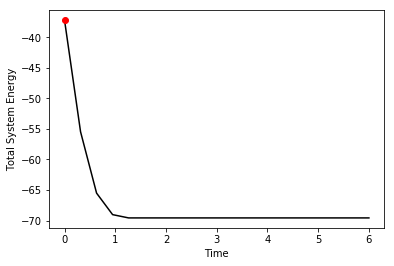

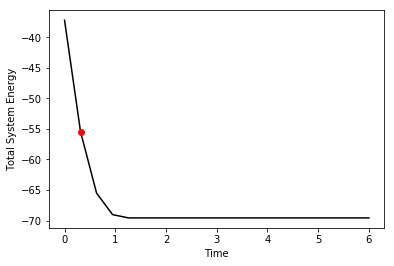

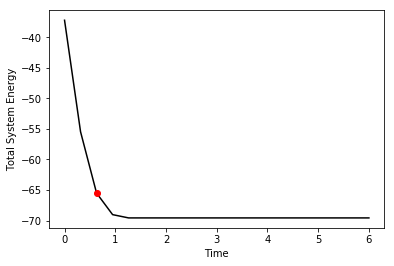

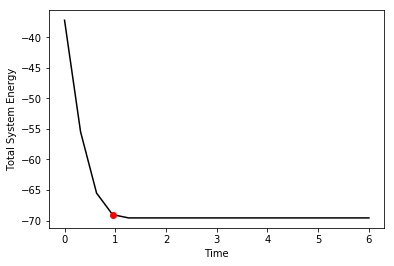

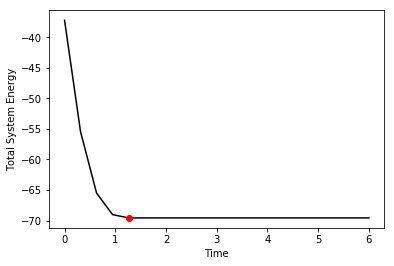

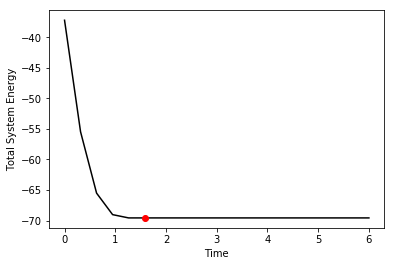

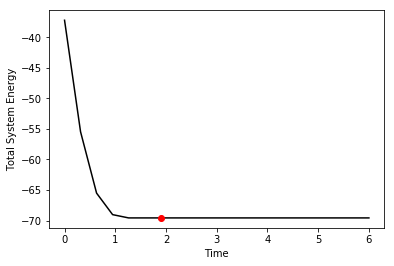

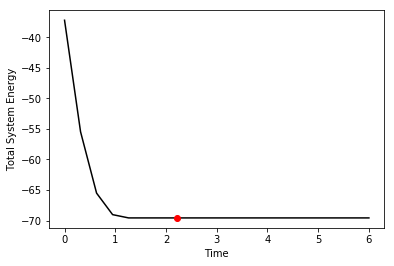

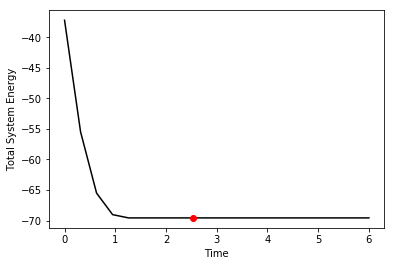

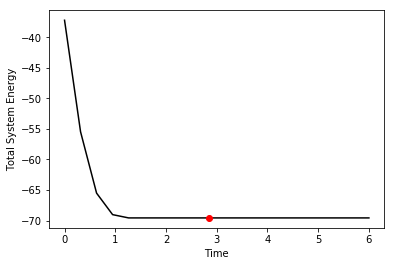

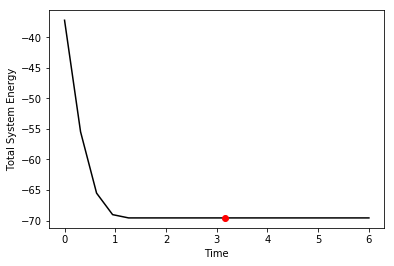

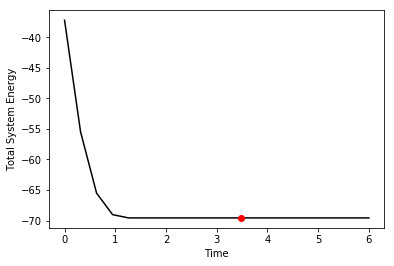

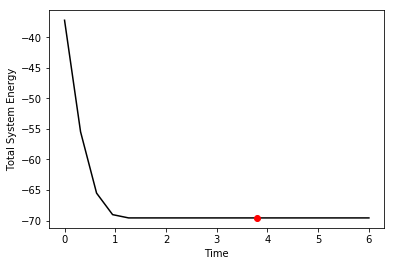

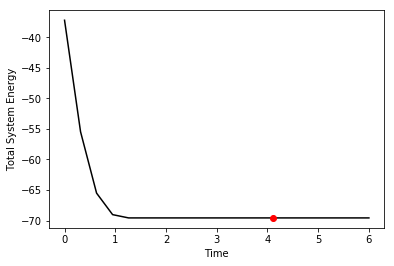

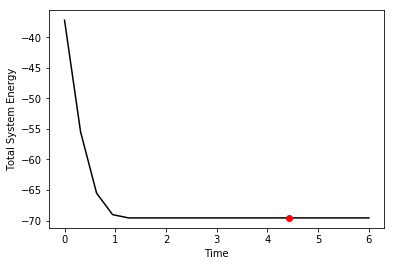

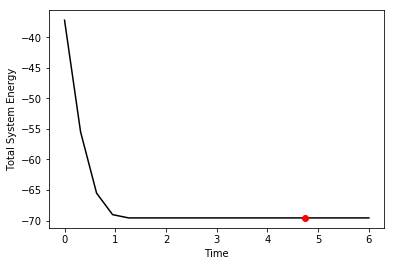

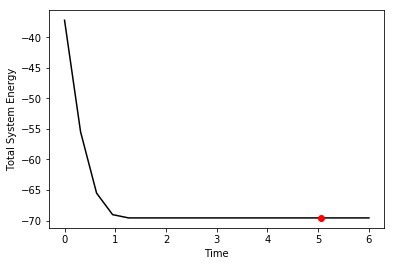

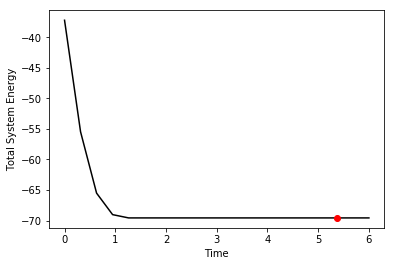

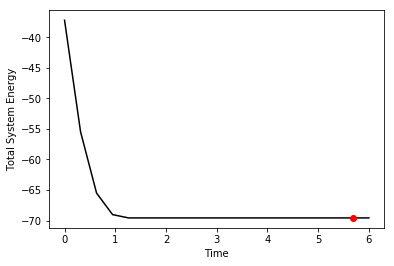

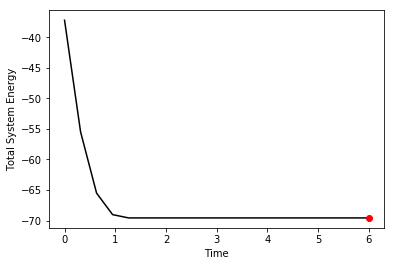

VBox(children=(VBox(children=(Figure(animation=400.0, animation_exponent=1.0, camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], scatters=[Scatter(color_selected=array('white',
      dtype='<U5'), connected=True, geo='sphere', size=array(2), size_selected=array(2.6), x=array([[  0.        ,   1.        ,   2.        ,   3.        ,
          4.        ,   5.        ,   6.        ,   7.        ,
          8.        ,   9.        ,  10.        ,  11.        ,
         12.        ,  13.        ,  14.        ],
       [  0.5200718 ,   1.50660522,   2.29893376,   2.99863116,
          4.25996618,   5.00676502,   5.77572721,   7.11130652,
          8.08648903,   8.81904139,   9.97277716,  11.04568711,
         11.5477967 ,  12.50211987,  13.47062401],
       [  0.52057142,   1.51575315,   2.50014193,   3.48656324,
          4.50206604,   5.23331642,   5.56645246,   7.43056149,
          8.22561851,   8.51926983,   9.50432738,  10.50452786,
         11.49228421,  12.50210267,  13.4672709 ],
       [  0.5205717 ,   1.51575466,   2.50016564,   3.48701408,
          4.51162052,   5.46805438,   5.59024982,   7.46706883,
          8.46355364,   8.52324419,   9.51227514,  10.5014649 ,
         11.48698499,  12.51055803,  13.46264236],
       [  0.5205717 ,   1.51575466,   2.50016565,   3.48701409,
          4.51162069,   5.46805761,   5.59031931,   7.46706136,
          8.4634138 ,   8.52024491,   9.51439603,  10.50006103,
         11.48683379,  12.51051266,  13.46251603],
       [  0.5205717 ,   1.51575466,   2.50016565,   3.48701409,
          4.51162069,   5.46805761,   5.59031938,   7.46706136,
          8.4634138 ,   8.52024491,   9.51439603,  10.50006102,
         11.48683373,  12.51051236,  13.46251445],
       [  0.5205717 ,   1.51575466,   2.50016565,   3.48701409,
          4.51162069,   5.46805761,   5.59031938,   7.46706136,
          8.4634138 ,   8.52024491,   9.51439603,  10.50006102,
         11.48683373,  12.51051236,  13.46251443],
       [  0.5205717 ,   1.51575466,   2.50016565,   3.48701409,
          4.51162069,   5.46805761,   5.59031938,   7.46706136,
          8.4634138 ,   8.52024491,   9.51439603,  10.50006102,
         11.48683373,  12.51051236,  13.46251443],
       [  0.5205717 ,   1.51575466,   2.50016565,   3.48701409,
          4.51162069,   5.46805761,   5.59031938,   7.46706136,
          8.4634138 ,   8.52024491,   9.51439603,  10.50006102,
         11.48683373,  12.51051236,  13.46251443],
       [  0.5205717 ,   1.51575466,   2.50016565,   3.48701409,
          4.51162069,   5.46805761,   5.59031938,   7.46706136,
          8.4634138 ,   8.52024491,   9.51439603,  10.50006102,
         11.48683373,  12.51051236,  13.46251443],
       [  0.5205717 ,   1.51575466,   2.50016565,   3.48701409,
          4.51162069,   5.46805761,   5.59031938,   7.46706136,
          8.4634138 ,   8.52024491,   9.51439603,  10.50006102,
         11.48683373,  12.51051236,  13.46251443],
       [  0.5205717 ,   1.51575466,   2.50016565,   3.48701409,
          4.51162069,   5.46805761,   5.59031938,   7.46706136,
          8.4634138 ,   8.52024491,   9.51439603,  10.50006102,
         11.48683373,  12.51051236,  13.46251443],
       [  0.5205717 ,   1.51575466,   2.50016565,   3.48701409,
          4.51162069,   5.46805761,   5.59031938,   7.46706136,
          8.4634138 ,   8.52024491,   9.51439603,  10.50006102,
         11.48683373,  12.51051236,  13.46251443],
       [  0.5205717 ,   1.51575466,   2.50016565,   3.48701409,
          4.51162069,   5.46805761,   5.59031938,   7.46706136,
          8.4634138 ,   8.52024491,   9.51439603,  10.50006102,
         11.48683373,  12.51051236,  13.46251443],
       [  0.5205717 ,   1.51575466,   2.50016565,   3.48701409,
          4.51162069,   5.46805761,   5.59031938,   7.46706136,
          8.4

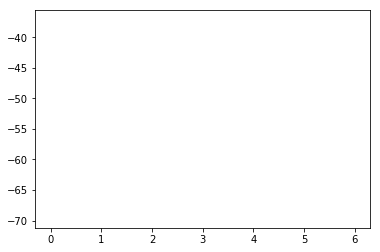

In [14]:
%matplotlib inline

# create an ipyvolume.pylab figure for the simulation
p3.figure()

# plot a scatterplot of the arrays defined above in the figure
s1 = p3.scatter(x, y, z, marker='sphere', connected=True)
s2 = p3.plot(x, y, z)

# set the x, y and z limits of the figure
p3.xlim(-50,120)
p3.ylim(-50,120)
p3.zlim(0,1)

# add animation controls to the figure
p3.animation_control([s1, s2], interval=400)

# add sliders for parameters
ns_slider = widgets.IntSlider(min=0, max=15, step=1, value=ns, description='ns', continuous_update=False)
w_slider = widgets.IntSlider(min=0, max=10, step=1, value=w, description='w', continuous_update=False)
sigma_slider = widgets.IntSlider(min=0, max=10, step=1, value=sigma, description='sigma', continuous_update=False)
k_s_text = widgets.FloatText(min=0., max=500., step=.1, value=k_s, description='k_s', continuous_update=False)
l_slider = widgets.IntSlider(min=0, max=10, step=1, value=l, description='l', continuous_update=False)

# create handler functions to change the values of the parameters globally when the sliders change
def on_ns_slider_change(change):
    global ns
    ns = change.new

def on_w_slider_change(change):
    global w
    w = change.new

def on_sigma_slider_change(change):
    global sigma
    sigma = sigma.new
    
def on_k_s_text_change(change):
    global k_s
    k_s = change.new
    
def on_l_slider_change(change):
    global l
    l = change.new

# set the sliders to call their handler functions any time the sliders are moved
ns_slider.observe(on_ns_slider_change, names='value')
w_slider.observe(on_w_slider_change, names='value')
sigma_slider.observe(on_sigma_slider_change, names='value')
k_s_text.observe(on_k_s_text_change, names='value')
l_slider.observe(on_l_slider_change, names='value')

# create a plot of the total system energy over time
f, ax = plt.subplots()

for i in range(len(t)):
    
    # set axes labels for the plot
    plt.xlabel('Time')
    plt.ylabel('Total System Energy')
    
    # plot the line and the current point on the line
    ax.plot(t, total_system_energy, 'k')
    ax.plot(t[i], total_system_energy[i], 'ro')
    
    # pause
    #time.sleep(0.1)
    
    # clear output, otherwise, we end up with len(t) graphs
    #clear_output()
    
    display(f)
    ax.cla()

# display the VBox beneath the total system energy plot
label = widgets.Label('Parameter sliders:')
parameters = widgets.VBox([ipv.gcc(), label, ns_slider, w_slider, sigma_slider, l_slider, k_s_text])
display(parameters)

In [ ]:
# print the output of odeint
pprint.pprint(gFlow)

In [ ]:
## Compute and print the distance between each pair of bonded atoms for debugging purposes
for i in range(int(m)-1):
    dist = norm(gFlow[-1,i*3:i*3+3] - gFlow[-1,i*3+3:i*3+6])
    print(str(dist)+', ')